In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import os
import json, time
import tensorflow as tf
import matplotlib.pyplot as plt
import evaluate
import numpy as np

from nltk import FreqDist
from qa_model import QAModel
from vocab import get_glove
from official_eval_helper import get_json_data, generate_answers
from operator import add

In [2]:
json_file = '../data/dev-v1.1.json'
qn_uuid_data, context_token_data, qn_token_data = get_json_data(json_file)

In [3]:
questions = [" ".join(q) for q in qn_token_data]
contexts  = [" ".join(c) for c in context_token_data]
len(questions)

10570

In [4]:
# what are the most common ways to begin questions
N = 20
question_starts = [" ".join(q) for q in [q.split()[:2] for q in questions]]
fd = FreqDist(question_starts)
most_common = fd.most_common(N)
least_common = fd.most_common()[-N:]
most_common

[(u'what is', 967),
 (u'how many', 543),
 (u'what was', 542),
 (u'what did', 376),
 (u'when did', 338),
 (u'when was', 243),
 (u'in what', 243),
 (u'what does', 221),
 (u'who was', 210),
 (u'what type', 193),
 (u'what are', 189),
 (u'how much', 138),
 (u'what do', 123),
 (u'where did', 123),
 (u'who did', 109),
 (u'who is', 97),
 (u'where was', 89),
 (u'what kind', 88),
 (u'how did', 79),
 (u'what year', 71)]

In [5]:
prediction_file = 'predictions.json'
with open(prediction_file) as prediction_file:
    predictions = json.load(prediction_file)

In [6]:
with open(json_file) as jf:
    dataset_json = json.load(jf)

In [7]:
evaluate.evaluate(dataset_json['data'], predictions)

{'exact_match': 60.00946073793756, 'f1': 70.99408517205993}

In [8]:
def find(lst, a):
    return [i for i, x in enumerate(lst) if x==a]

def getIdx(main_list, indexes):
    return [main_list[x] for x in indexes]

In [9]:
ids = [[] for i in range(N)]
for cnt,mc in enumerate(most_common):
    ids[cnt] = getIdx(qn_uuid_data, find(question_starts,mc[0]))

In [10]:
s = []
for cnt, thisid in enumerate(ids):
    print(most_common[cnt][0])
    s.append(evaluate.masked_evaluate(dataset_json['data'], predictions, thisid))

In [11]:
em = list(zip(*s)[0])
f1 = list(zip(*s)[1])
labs = [mc[0] + " (" + str(mc[1]) + ")" for mc in most_common]

_, em_sorted, f1_sorted, labs_sorted = zip(*sorted(zip(map(add, em, f1), em, f1, labs)))

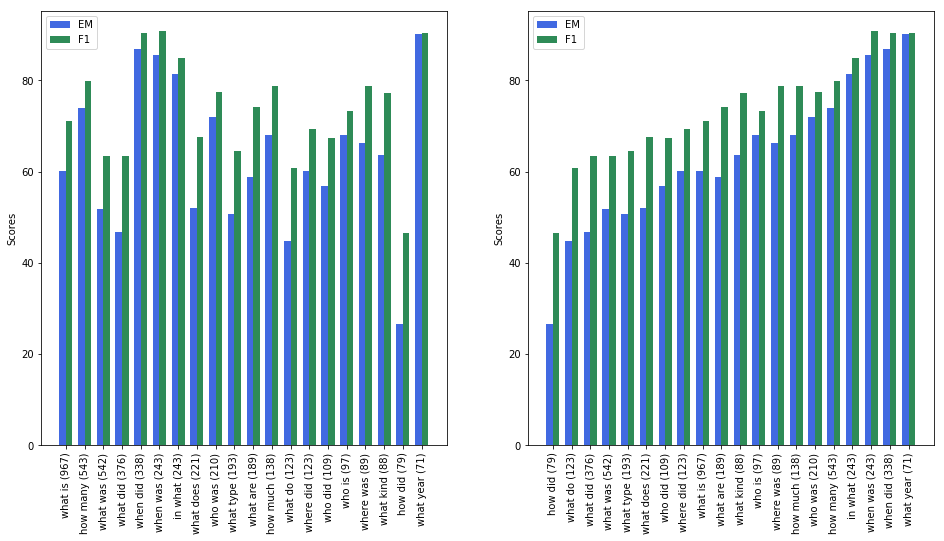

In [16]:
plotidx = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

plt.rcParams['figure.figsize'] = (16.0, 8.0)
fig = plt.figure()
ax = fig.add_subplot(121)
rects1 = ax.bar(plotidx, em, width, color='royalblue')
rects2 = ax.bar(plotidx+width, f1, width, color='seagreen')
ax.set_ylabel('Scores')
ax.set_xticks(plotidx + width / 2)
ax.set_xticklabels(labs)
plt.xticks(rotation=90)
ax.legend(('EM', 'F1') )

ax = fig.add_subplot(122)
rects1 = ax.bar(plotidx, em_sorted, width, color='royalblue')
rects2 = ax.bar(plotidx+width, f1_sorted, width, color='seagreen')
ax.set_ylabel('Scores')
ax.set_xticks(plotidx + width / 2)
ax.set_xticklabels(labs_sorted)
plt.xticks(rotation=90)
ax.legend(('EM', 'F1') )

plt.savefig('./figs/mostcommon.pdf', format='pdf')
plt.show()

In [17]:
_, word2id, _ = get_glove('../data/glove.6B.50d.txt', 50)
vocab = set(word2id.keys())

In [18]:
len(vocab)

400002

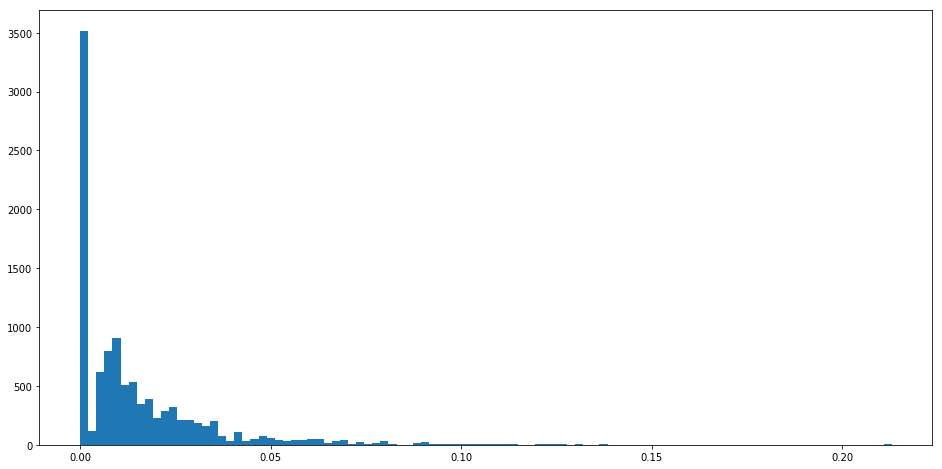

In [19]:
x = [sum(q in vocab for q in context_token)/float(len(context_token)) for context_token in context_token_data]
oov_frac = 1 - np.array(x)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(oov_frac, bins=100)
plt.show()

In [33]:
M = 3
thresholds = np.linspace(0, 0.2, M)
uuid_masks = [list(np.array(qn_uuid_data)[oov_frac <= thresh]) for thresh in thresholds]

In [34]:
s = []
for cnt, uuid_mask in enumerate(uuid_masks):
    s.append(evaluate.masked_evaluate(dataset_json['data'], predictions, uuid_mask))

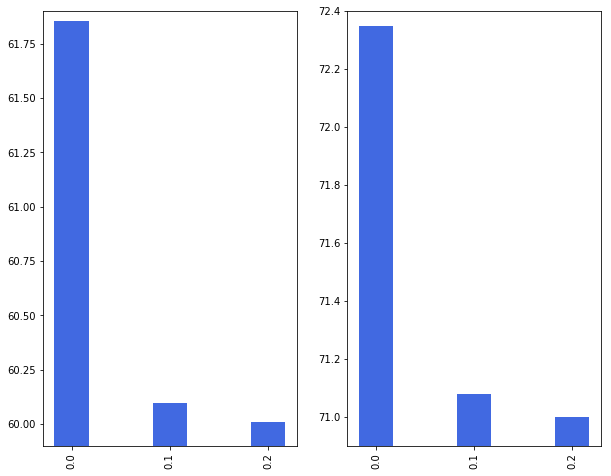

In [43]:
em = list(zip(*s)[0])
f1 = list(zip(*s)[1])

plotidx = np.arange(M)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
fig = plt.figure()

ax = fig.add_subplot(121)
rects1 = ax.bar(plotidx,em, width, color='royalblue')
ax.set_xticks(plotidx)
ax.set_xticklabels(thresholds)
plt.xticks(rotation=90)
ax.set_ylim([59.9,61.9])

ax = fig.add_subplot(122)
rects1 = ax.bar(plotidx,f1, width, color='royalblue')
ax.set_xticks(plotidx)
ax.set_xticklabels(thresholds)
plt.xticks(rotation=90)
ax.set_ylim([70.9,72.4])

plt.savefig('./figs/oov.pdf', format='pdf')
plt.show() # at most


In [32]:
np.amax(oov_frac)

0.2129629629629629